# Titanic: Machine Learning from Disaster

## Problem Statement

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [4]:
##Imports

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


## Descriptive Statistics

In [21]:
# Transform csv files to corresponding pandas DataFrames
train_df = pd.read_csv('data/train.csv')
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [22]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
test_df = pd.read_csv('data/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [25]:
train_df.info()
print('-'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

In [29]:
## Incomplete Columns in Training and Test Data
print("Incomplete Training Data Columns: ")
print(np.sum(train_df.loc[:,train_df.isnull().any(axis=0)==True].isnull()))
print("Incomplete Testing Data Columns: ")
print(np.sum(test_df.loc[:,train_df.isnull().any(axis=0)==True].isnull()))

Incomplete Training Data Columns: 
Age         177
Cabin       687
Embarked      2
dtype: int64
Incomplete Testing Data Columns: 
Age          86
Cabin       327
Embarked      0
dtype: int64


### Observations:

Although both cabin and Age have significant missing entries in both Training and Test columns, my hypothesis is that they have significant correlation with Survival rate.

In [30]:
#Description of Numerical Variables
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [39]:
#Description of Categorical variables
#train_df.describe(include=['O'])
train_df['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

### Observations

1. Survival rate in training data is 38.38%

2. 65% male population

3. Cabin feature is not unique to passenger with 147 unique entries. This indicates multiple passengers might share the same cabin.

4. Majority of passengers (72.44%) embarked upon Titanic at the Southampton port.

### Hypothesis

Categories of passenger with likely higher survival rate, as mentioned in Problem Statement,

1) Women 

2) Children

3) Pclass = 1 passengers

## Uni-Variate Analysis

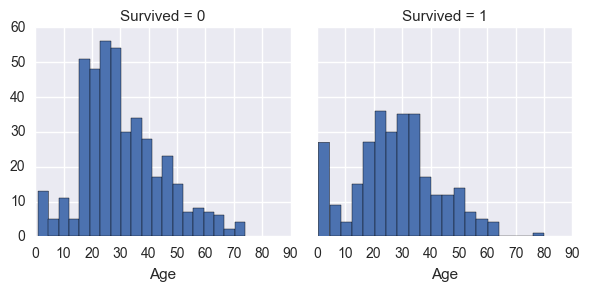

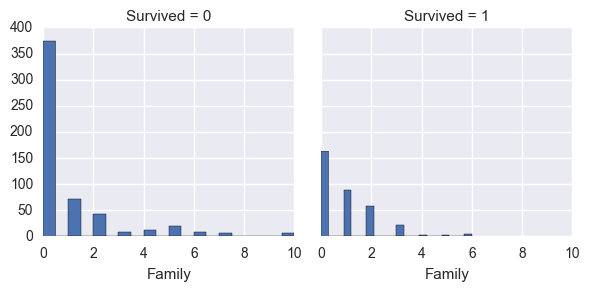

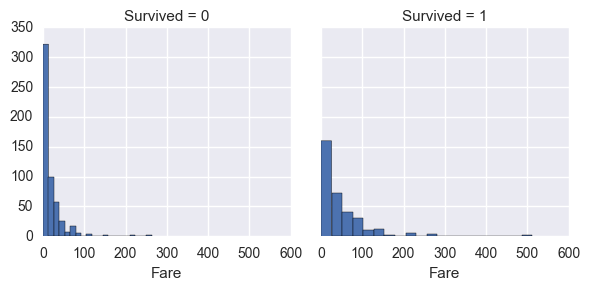

In [69]:
# Adding Family as a new Feature column in train_df. Family = Parch + SibSp
train_df['Family'] = train_df['Parch'] + train_df['SibSp']

num_features = ['Age','Family','Fare'] #numerical features
#train_df.drop(['Survived','Name','Ticket','Cabin','Sex','Embarked'],axis=1).columns.values

for i in num_features:
    g = sns.FacetGrid(train_df, col='Survived')
    g.map(plt.hist, i, bins=20)

### Observations:

1. Most passengers are in the age group of 15-35 years.

2. Large number of 15-30 year olds didn't survive.

3. Children (age <= 5) have high survival rate

4. For family sizes in the range 1-3, survived > not survived

## Bi-Variate Analysis

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/linearmodels.py:1290: UserWarning: The `corrplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warnings.warn(("The `corrplot` function has been deprecated in favor "
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/seaborn/linearmodels.py:1356: UserWarning: The `symmatplot` function has been deprecated in favor of `heatmap` and will be removed in a forthcoming release. Please update your code.
  warning

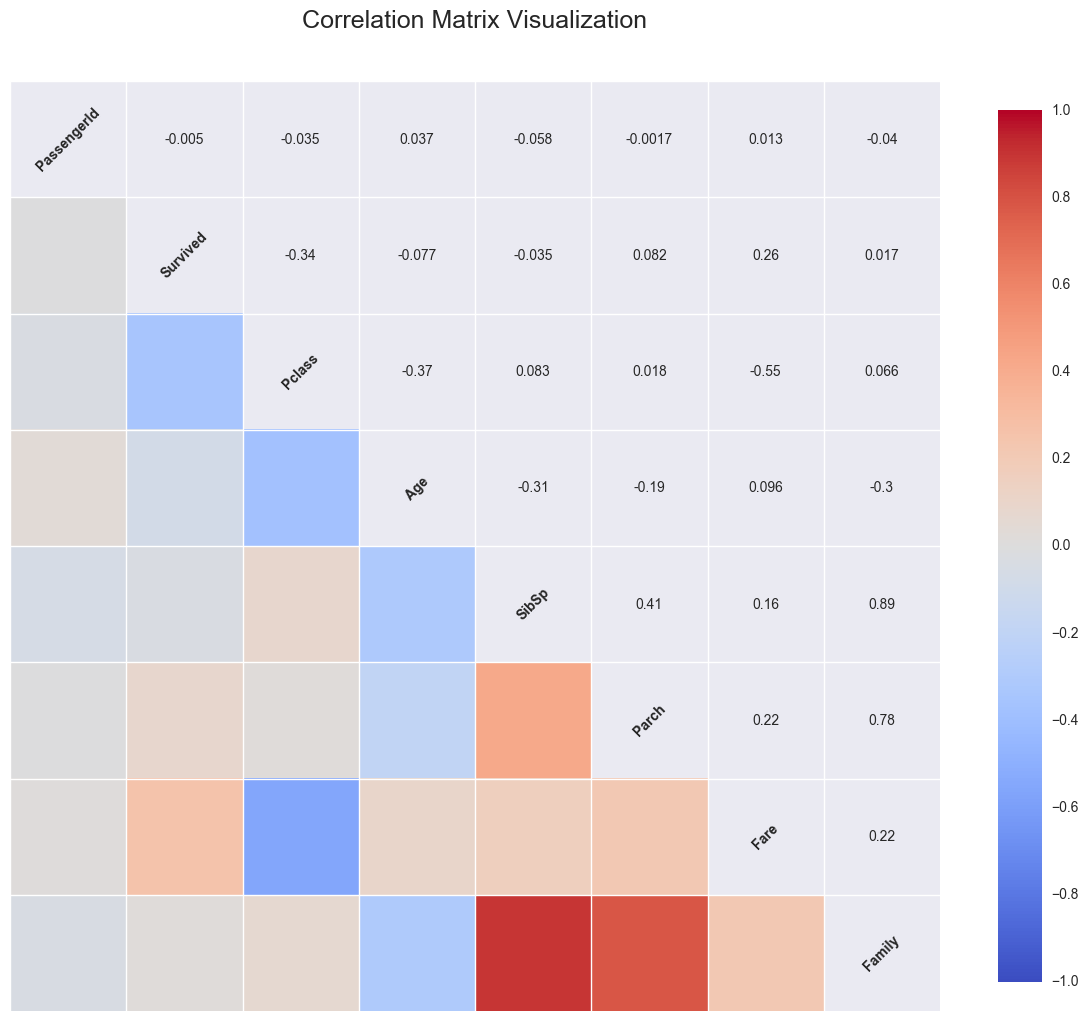

In [70]:
fig = plt.figure(figsize=(15,15))
sns.linearmodels.corrplot(train_df)
plt.title("Correlation Matrix Visualization",fontsize=18)